# Исследование влияния погодных условий на транспортный поток

## imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import glob
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
path = '/home/markloop/datasets/speed/'
path_weather = '/home/markloop/datasets/speed/weather.xlsx'

In [5]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

In [6]:
files = glob.glob(path + "speed_*.csv")
files.sort(key=natural_sort_key)
relevant_columns = ['measuretimeutc', 'volume', 'cross1', 'cross2', 'speed', 'occupancy', 'direct']

In [7]:
dataframes = []

In [8]:
for file in files:
    df = pd.read_csv(file, usecols=relevant_columns)
    dataframes.append(df)

In [9]:
df_traffic = pd.concat(dataframes, ignore_index=True)

In [10]:
df_weather = pd.read_excel(path_weather)

## cleanup

### df_traffic

In [13]:
df_traffic['measuretimeutc'] = pd.to_datetime(df_traffic['measuretimeutc'])

In [14]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067077 entries, 0 to 1067076
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   measuretimeutc  1067077 non-null  datetime64[ns]
 1   volume          1067077 non-null  int64         
 2   speed           1067077 non-null  float64       
 3   occupancy       1067077 non-null  float64       
 4   cross1          1067077 non-null  int64         
 5   cross2          1067077 non-null  int64         
 6   direct          1067077 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 57.0 MB


In [15]:
df_traffic.head(12)

,measuretimeutc,volume,speed,occupancy,cross1,cross2,direct
0,2023-01-01 00:05:00,336,15.4601,13.04,93,97,2
1,2023-01-01 00:05:00,180,21.4286,2.52,127,97,0
2,2023-01-01 00:05:00,180,24.1071,2.24,127,97,0
3,2023-01-01 00:05:00,60,23.6842,1.52,93,97,1
4,2023-01-01 00:05:00,852,18.0508,7.08,93,97,0
5,2023-01-01 00:05:00,228,20.3571,6.72,93,97,3
6,2023-01-01 00:10:00,192,22.1538,5.20,93,97,3
7,2023-01-01 00:10:00,132,14.5588,2.72,127,97,0
8,2023-01-01 00:10:00,36,18.0000,1.20,93,97,1
9,2023-01-01 00:10:00,48,30.0000,0.48,127,97,0


In [16]:
df_traffic.describe()

,measuretimeutc,volume,speed,occupancy,cross1,cross2,direct
count,1067077,1.067077e+06,1.067077e+06,1.067077e+06,1.067077e+06,1067077.0,1.067077e+06
mean,2023-06-30 00:13:41.479050752,5.110795e+02,2.456094e+01,1.262779e+01,1.107443e+02,97.0,1.471167e+00
min,2023-01-01 00:05:00,0.000000e+00,-1.000000e+00,0.000000e+00,9.300000e+01,97.0,0.000000e+00
25%,2023-04-01 04:45:00,1.080000e+02,1.538110e+01,2.200000e+00,9.300000e+01,97.0,0.000000e+00
50%,2023-06-30 01:30:00,3.480000e+02,2.486840e+01,7.840000e+00,1.270000e+02,97.0,1.000000e+00
75%,2023-09-28 22:45:00,6.720000e+02,3.214290e+01,1.696000e+01,1.270000e+02,97.0,2.000000e+00
max,2023-12-31 00:00:00,4.392000e+03,5.400000e+02,1.000000e+02,1.270000e+02,97.0,4.000000e+00
std,NaN,6.129386e+02,1.613423e+01,1.475276e+01,1.698371e+01,0.0,1.249684e+00


In [17]:
df_traffic = df_traffic[(df_traffic['speed'] >= 0) & (df_traffic['speed'] <= 150)]

In [18]:
df_traffic.isna().sum()

measuretimeutc    0
volume            0
speed             0
occupancy         0
cross1            0
cross2            0
direct            0
dtype: int64

### df_weather

In [20]:
df_weather.head(1)

,Дата время,Температура,Ощущается как,"Давление, мм рт.ст.",Влажность,Точка росы,"Облачность, %",УФ-Индекс,"Видимость, м",Скорость ветра,Порывы ветра,"Направление ветра, град.",Погодные условия,"Дождь, мм/ч","Снег, мм/ч",Восход,Закат
0,2023-01-01 00:00:00,-4.93,-10.03,763,93,-5.78,100.0,NaN,NaN,3.63,NaN,119.0,небольшой снег,NaN,0.24,2023-01-01 08:13:41,2023-01-01 15:19:40


In [21]:
df_weather = df_weather[['Дата время', 'Температура', 'Влажность', 'Облачность, %', 
                                   'Скорость ветра', 'Направление ветра, град.', 'Погодные условия', 
                                   'Дождь, мм/ч', 'Снег, мм/ч']]

df_weather.columns = ['datetime', 'temperature', 'humidity', 'cloudiness', 
                                'wind_speed', 'wind_direction', 'weather_conditions', 
                                'rain', 'snow']

In [22]:
df_weather.head()

,datetime,temperature,humidity,cloudiness,wind_speed,wind_direction,weather_conditions,rain,snow
0,2023-01-01 00:00:00,-4.93,93,100.0,3.63,119.0,небольшой снег,NaN,0.24
1,2023-01-01 02:00:00,-5.08,93,100.0,2.59,121.0,пасмурно,NaN,NaN
2,2023-01-01 04:00:00,-5.04,93,97.0,1.48,141.0,пасмурно,NaN,NaN
3,2023-01-01 06:00:00,-4.98,93,95.0,1.85,145.0,пасмурно,NaN,NaN
4,2023-01-01 08:00:00,-4.30,93,96.0,1.91,180.0,пасмурно,NaN,NaN


In [23]:
df_weather.isna().sum()

datetime                 0
temperature              1
humidity                 0
cloudiness             429
wind_speed               0
wind_direction           2
weather_conditions       0
rain                  4128
snow                  4131
dtype: int64

In [24]:
missing_temp_index = df_weather[df_weather['temperature'].isna()].index

if not missing_temp_index.empty:
    index = missing_temp_index[0]  
    start_index = max(0, index - 1)  
    end_index = min(len(df_weather), index + 2)  
    print(df_weather.iloc[start_index:end_index])

                 datetime  temperature  humidity  cloudiness  wind_speed  \
3606  2023-10-28 12:00:00        -0.60        93       100.0        4.23   
3607  2023-10-28 14:00:00          NaN        90       100.0        3.97   
3608  2023-10-28 16:00:00        -0.21        92       100.0        4.28   

      wind_direction weather_conditions  rain  snow  
3606           107.0           пасмурно   NaN   NaN  
3607           100.0           пасмурно   NaN   NaN  
3608            94.0           пасмурно   NaN   NaN  


In [25]:
df_weather['cloudiness'] = df_weather['cloudiness'].fillna(0)
df_weather['wind_direction'] = df_weather['wind_direction'].fillna(0)
df_weather['temperature'] = df_weather['temperature'].fillna(0)
df_weather['rain'] = df_weather['rain'].fillna(0)
df_weather['snow'] = df_weather['snow'].fillna(0)

## EDA

In [27]:
df_traffic['hour'] = df_traffic['measuretimeutc'].dt.hour
hourly_car_count = df_traffic.groupby('hour')['volume'].sum().reset_index()
hourly_speed = df_traffic.groupby('hour')['speed'].mean().reset_index()

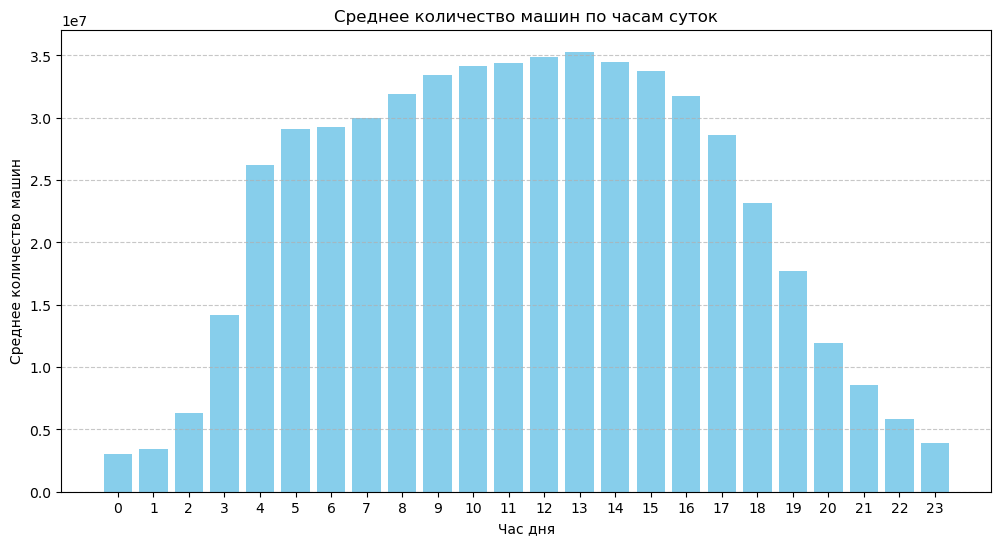

In [28]:
plt.figure(figsize=(12, 6))
plt.bar(hourly_car_count['hour'], hourly_car_count['volume'], color='skyblue')
plt.xlabel('Час дня')
plt.ylabel('Среднее количество машин')
plt.title('Среднее количество машин по часам суток')
plt.xticks(range(24))  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

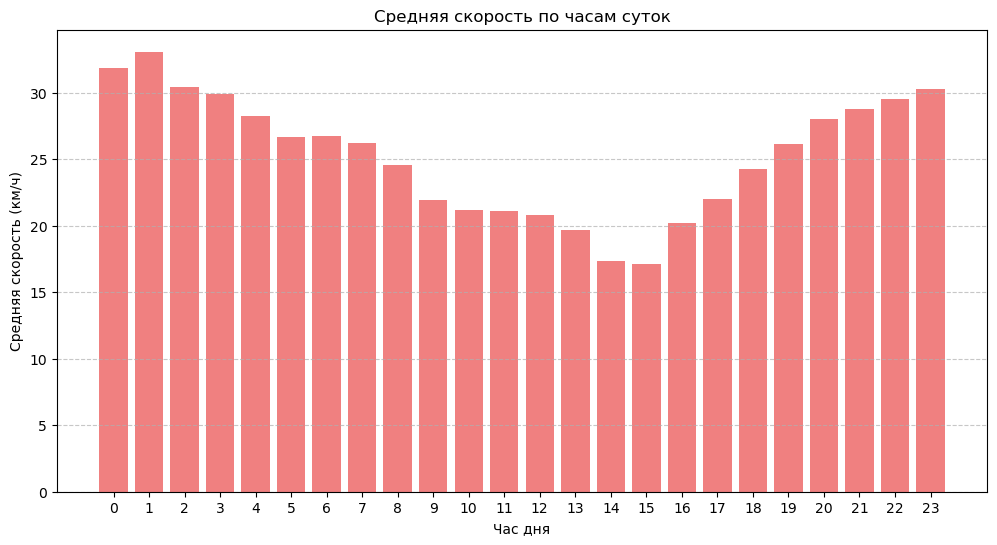

In [29]:
plt.figure(figsize=(12, 6))
plt.bar(hourly_speed['hour'], hourly_speed['speed'], color='lightcoral')
plt.xlabel('Час дня')
plt.ylabel('Средняя скорость (км/ч)')
plt.title('Средняя скорость по часам суток')
plt.xticks(range(24)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
df_traffic['day_of_week'] = df_traffic['measuretimeutc'].dt.dayofweek
daily_car_count = df_traffic.groupby('day_of_week')['volume'].sum().reset_index()
daily_speed = df_traffic.groupby('day_of_week')['speed'].mean().reset_index()

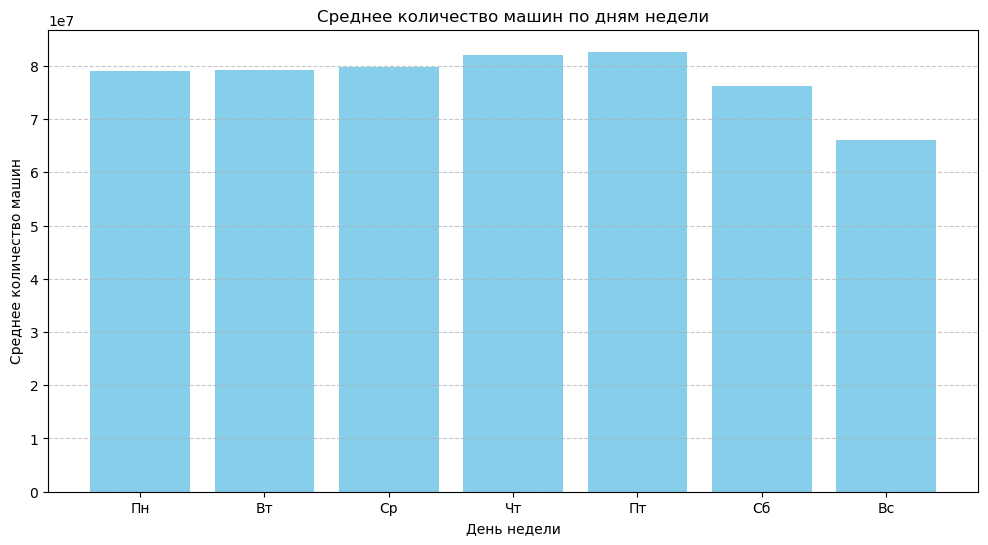

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(daily_car_count['day_of_week'], daily_car_count['volume'], color='skyblue')
plt.xlabel('День недели')
plt.ylabel('Среднее количество машин')
plt.title('Среднее количество машин по дням недели')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

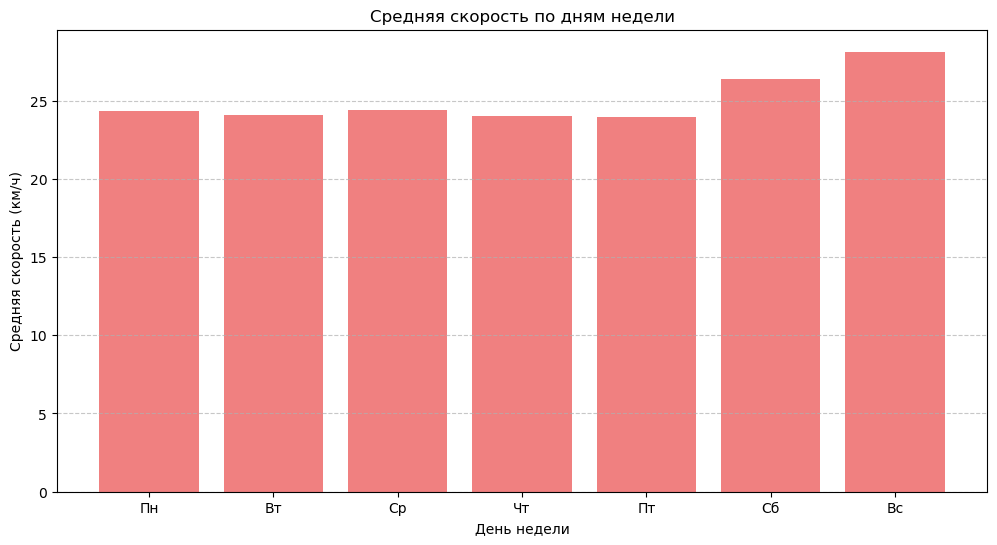

In [32]:
plt.figure(figsize=(12, 6))
plt.bar(daily_speed['day_of_week'], daily_speed['speed'], color='lightcoral')
plt.xlabel('День недели')
plt.ylabel('Средняя скорость (км/ч)')
plt.title('Средняя скорость по дням недели')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
df_traffic['month'] = df_traffic['measuretimeutc'].dt.month
monthly_car_count = df_traffic.groupby('month')['volume'].sum().reset_index()
monthly_speed = df_traffic.groupby('month')['speed'].mean().reset_index()

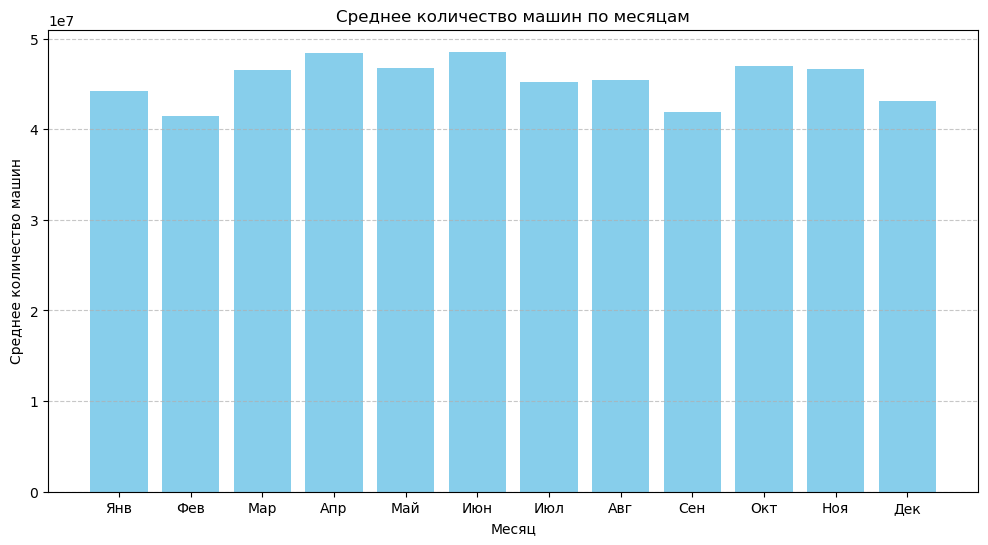

In [34]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_car_count['month'], monthly_car_count['volume'], color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество машин')
plt.title('Среднее количество машин по месяцам')
plt.xticks(ticks=range(1, 13), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                                          'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

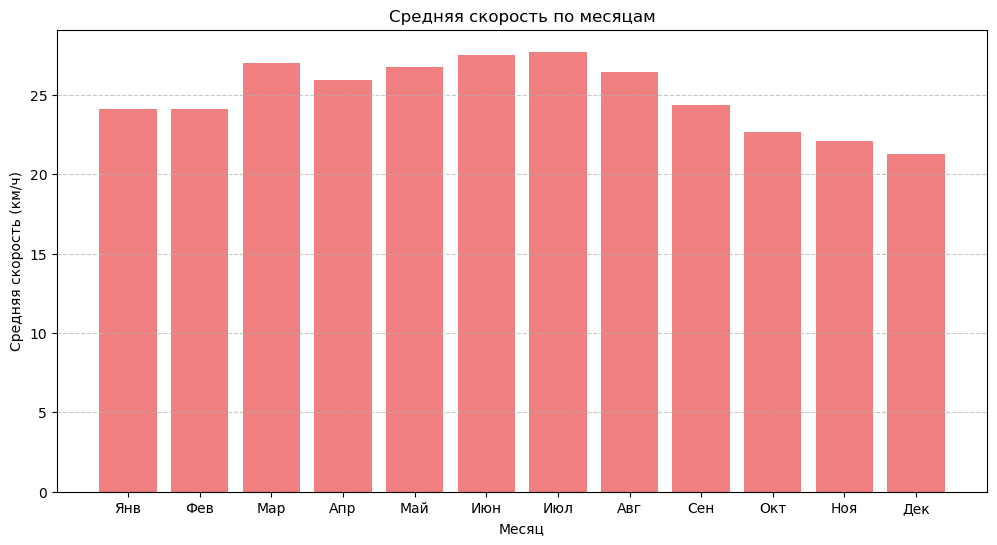

In [35]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_speed['month'], monthly_speed['speed'], color='lightcoral')
plt.xlabel('Месяц')
plt.ylabel('Средняя скорость (км/ч)')
plt.title('Средняя скорость по месяцам')
plt.xticks(ticks=range(1, 13), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                                          'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [36]:
season_labels = ['Зима', 'Весна', 'Лето', 'Осень']
season_months = {
    'Зима': [12, 1, 2],
    'Весна': [3, 4, 5],
    'Лето': [6, 7, 8],
    'Осень': [9, 10, 11]}

monthly_car_count['season'] = monthly_car_count['month'].map(
    {month: season for season, months in season_months.items() for month in months})

monthly_speed['season'] = monthly_speed['month'].map(
    {month: season for season, months in season_months.items() for month in months})

In [37]:
seasonal_car_count = monthly_car_count.groupby('season')['volume'].mean().reindex(season_labels)
seasonal_speed = monthly_speed.groupby('season')['speed'].mean().reindex(season_labels)

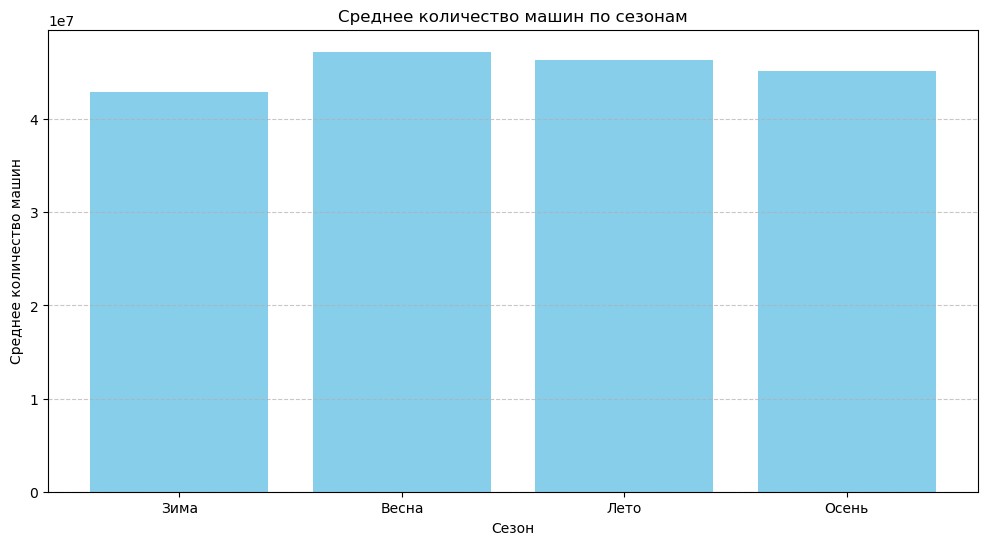

In [38]:
plt.figure(figsize=(12, 6))
plt.bar(seasonal_car_count.index, seasonal_car_count, color='skyblue')
plt.xlabel('Сезон')
plt.ylabel('Среднее количество машин')
plt.title('Среднее количество машин по сезонам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

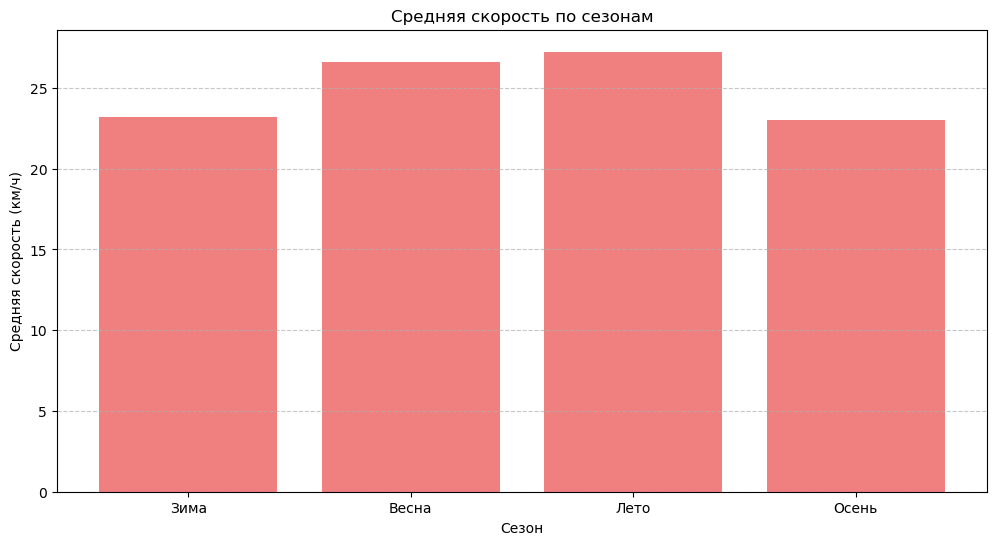

In [39]:
plt.figure(figsize=(12, 6))
plt.bar(seasonal_speed.index, seasonal_speed, color='lightcoral')
plt.xlabel('Сезон')
plt.ylabel('Средняя скорость (км/ч)')
plt.title('Средняя скорость по сезонам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## timeseries analysis

In [41]:
df_traffic['date'] = df_traffic['measuretimeutc'].dt.date
df_daily = df_traffic.groupby('date').agg({
    'speed': 'mean',  
    'volume': 'sum' 
}).reset_index()
df_daily.set_index('date', inplace=True)

df_daily.index = pd.to_datetime(df_daily.index)
df_daily = df_daily.asfreq('D')

In [42]:
result_speed = seasonal_decompose(df_daily['speed'], model='additive', period=30) 
result_count = seasonal_decompose(df_daily['volume'], model='additive', period=30) 

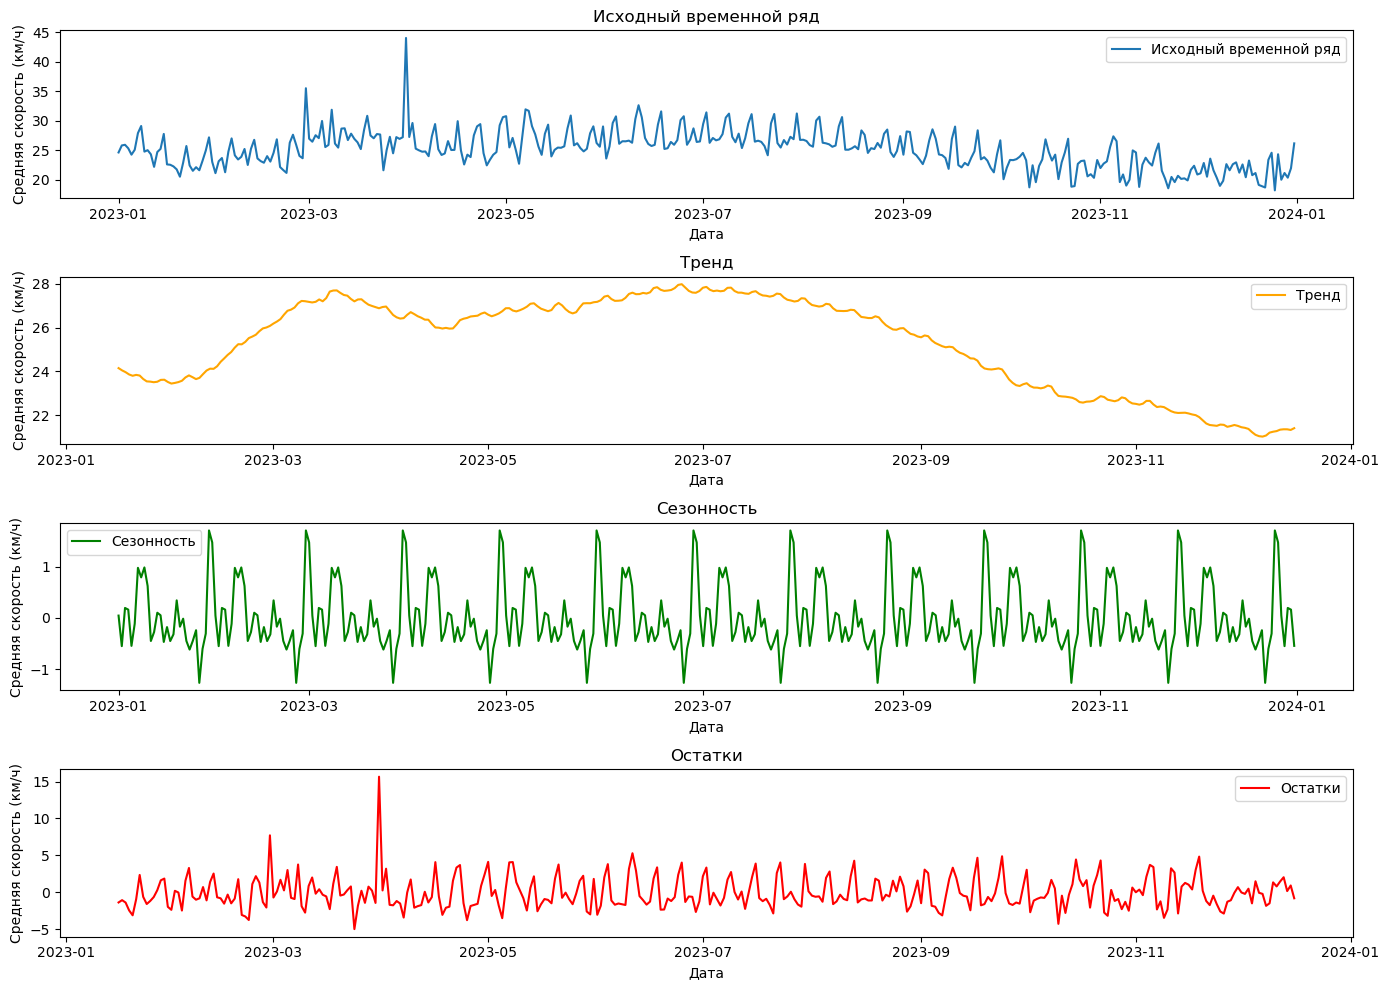

In [43]:
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df_daily['speed'], label='Исходный временной ряд')
plt.title('Исходный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Средняя скорость (км/ч)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result_speed.trend, label='Тренд', color='orange')
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Средняя скорость (км/ч)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result_speed.seasonal, label='Сезонность', color='green')
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Средняя скорость (км/ч)')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result_speed.resid, label='Остатки', color='red')
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Средняя скорость (км/ч)')
plt.legend()

plt.tight_layout()
plt.show()

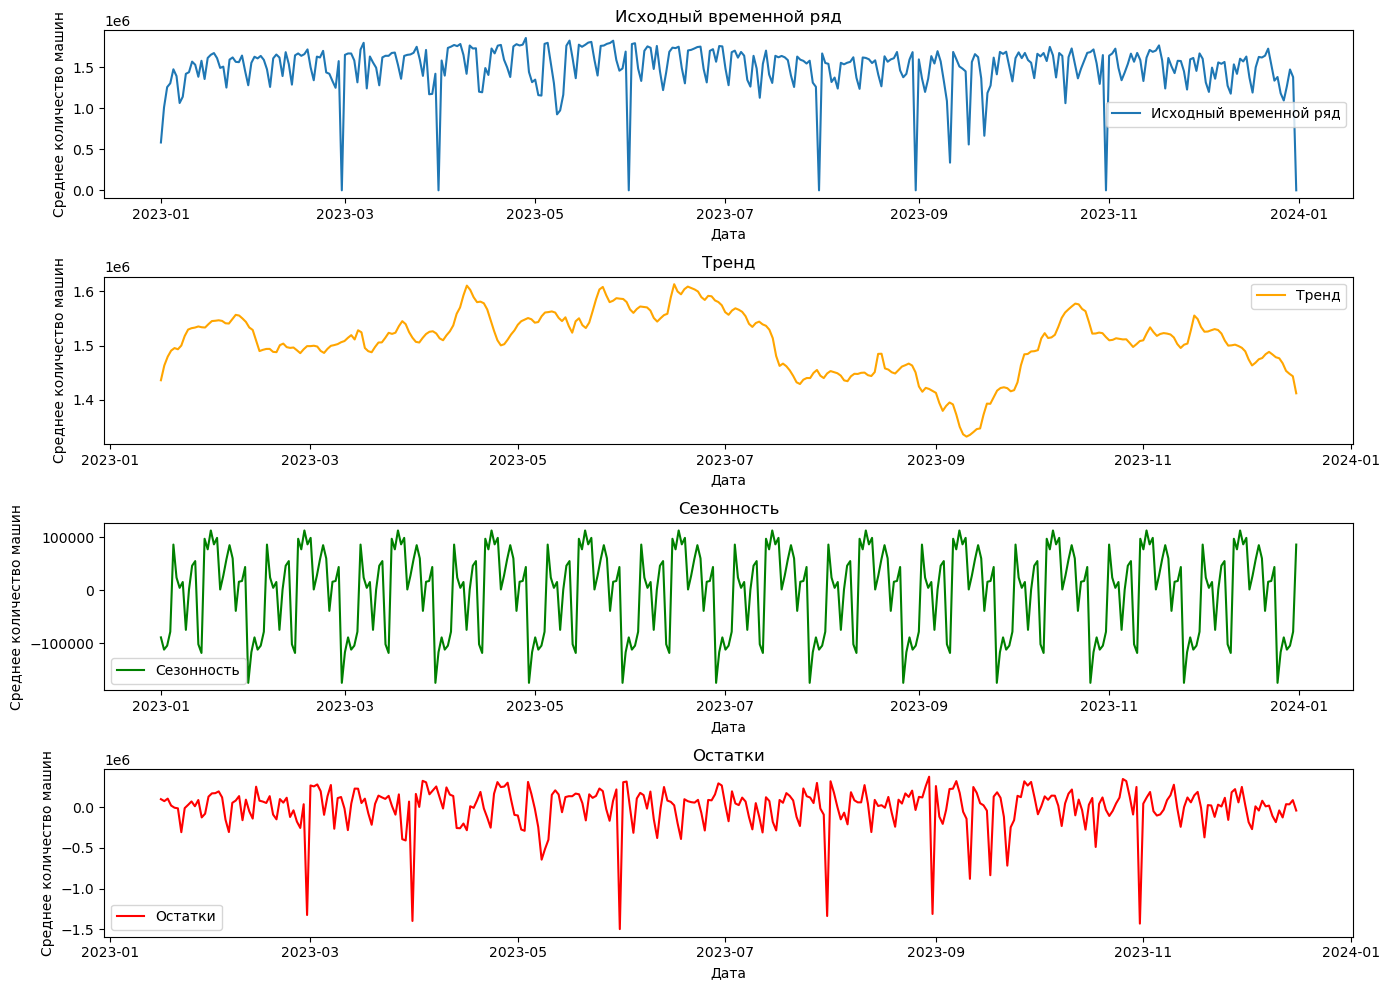

In [44]:
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df_daily['volume'], label='Исходный временной ряд')
plt.title('Исходный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Среднее количество машин')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result_count.trend, label='Тренд', color='orange')
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Среднее количество машин')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result_count.seasonal, label='Сезонность', color='green')
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Среднее количество машин')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result_count.resid, label='Остатки', color='red')
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Среднее количество машин')
plt.legend()

plt.tight_layout()
plt.show()

Видим отсутствие четкого тренда на больших промежутках времени. Тем временем сезонность имеет четкую закономерность. Это может повлиять на исследование, попробуем учесть это. Скорее всего дело в недельной сезонности. Разумеется использовать декомпозицию ряда, ресемплированного по часам для нашего изначального датафрейма мы не можем.

In [46]:
df_traffic['measuretimeutc'] = pd.to_datetime(df_traffic['measuretimeutc'])


In [47]:
result_speed_deseason = seasonal_decompose(df_traffic['speed'], model='additive', period=288*7)  # в сутках 288 пятиминуток
result_volume_deseason = seasonal_decompose(df_traffic['volume'], model='additive', period=288*7)

In [48]:
df_traffic['speed_deseasonalized'] = df_traffic['speed'] - result_speed_deseason.seasonal
df_traffic['volume_deseasonalized'] = df_traffic['volume'] - result_volume_deseason.seasonal

## merging

Объединяем данные, ресемплируем данные по 2ч и группируем по направлению движения, каждое направление анализируем отдельно.

In [51]:
df_traffic.set_index('measuretimeutc', inplace=True)

In [52]:
df_traffic_resampled = df_traffic.groupby(['cross1', 'cross2', 'direct']).resample('2h').agg({  # уникальная пара 
    'volume_deseasonalized': 'sum',                                                       # cross'ов соотв. уникальному направлению
    'speed_deseasonalized': 'mean',
}).reset_index()

In [53]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

In [54]:
merged_df = pd.merge_asof(df_traffic_resampled.sort_values('measuretimeutc'),
                           df_weather.sort_values('datetime'),
                           left_on='measuretimeutc', right_on='datetime',
                           direction='backward')

In [55]:
merged_df.drop(columns=['datetime'], inplace=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')
weather_encoded = encoder.fit_transform(merged_df[['weather_conditions']])
weather_encoded_df = pd.DataFrame(weather_encoded, columns=encoder.get_feature_names_out(['weather_conditions']))

In [56]:
merged_df = pd.concat([merged_df.reset_index(drop=True), weather_encoded_df.reset_index(drop=True)], axis=1)

In [57]:
merged_df = merged_df.dropna()

In [155]:
merged_df_filtered = merged_df[merged_df['direct'] == 0] #записи с direct0 = по всему направлению

In [59]:
merged_df_filtered.columns

Index(['cross1', 'cross2', 'direct', 'measuretimeutc', 'volume_deseasonalized',
       'speed_deseasonalized', 'temperature', 'humidity', 'cloudiness',
       'wind_speed', 'wind_direction', 'weather_conditions', 'rain', 'snow',
       'weather_conditions_небольшая облачность',
       'weather_conditions_небольшой дождь',
       'weather_conditions_небольшой снег',
       'weather_conditions_облачно с прояснениями',
       'weather_conditions_пасмурно',
       'weather_conditions_переменная облачность', 'weather_conditions_снег',
       'weather_conditions_ясно'],
      dtype='object')

## Анализ

### Корреляционный

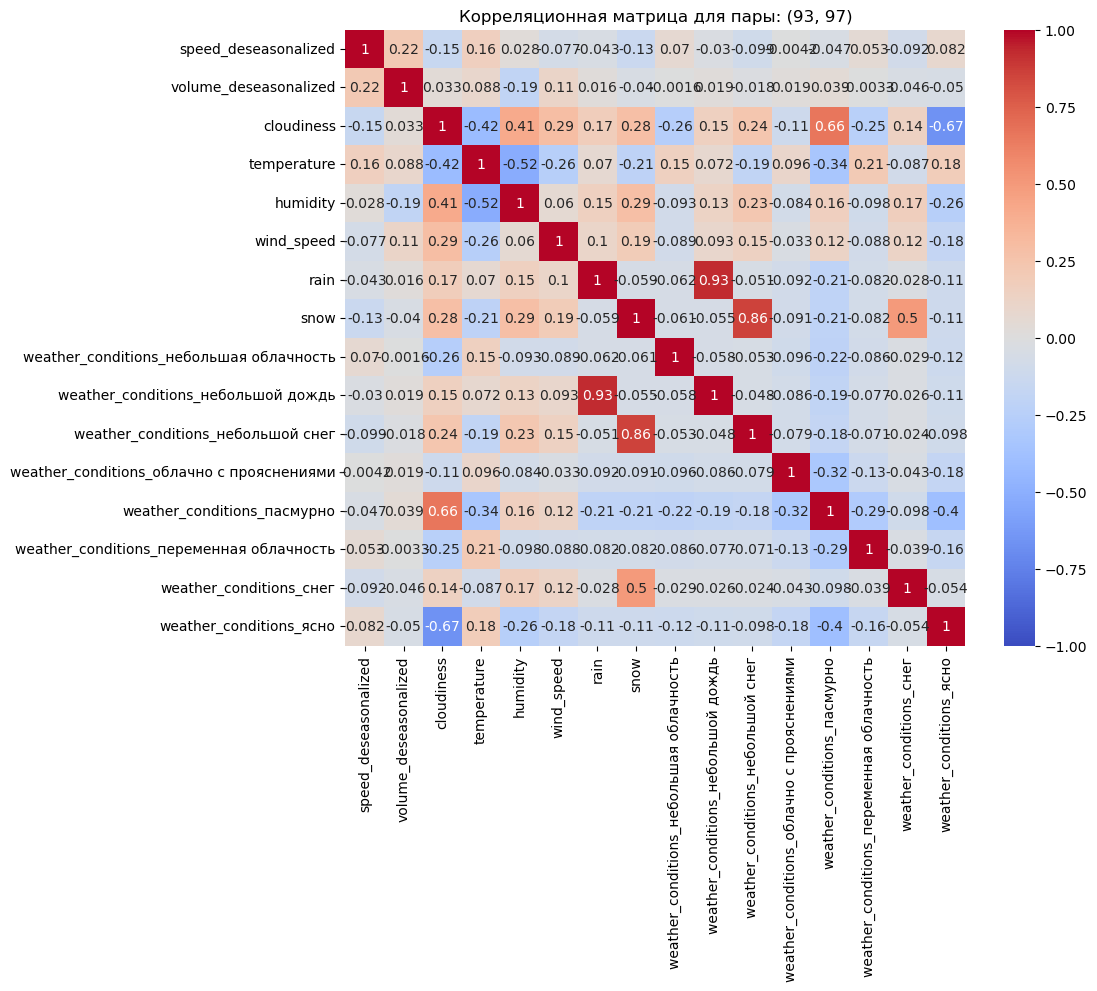

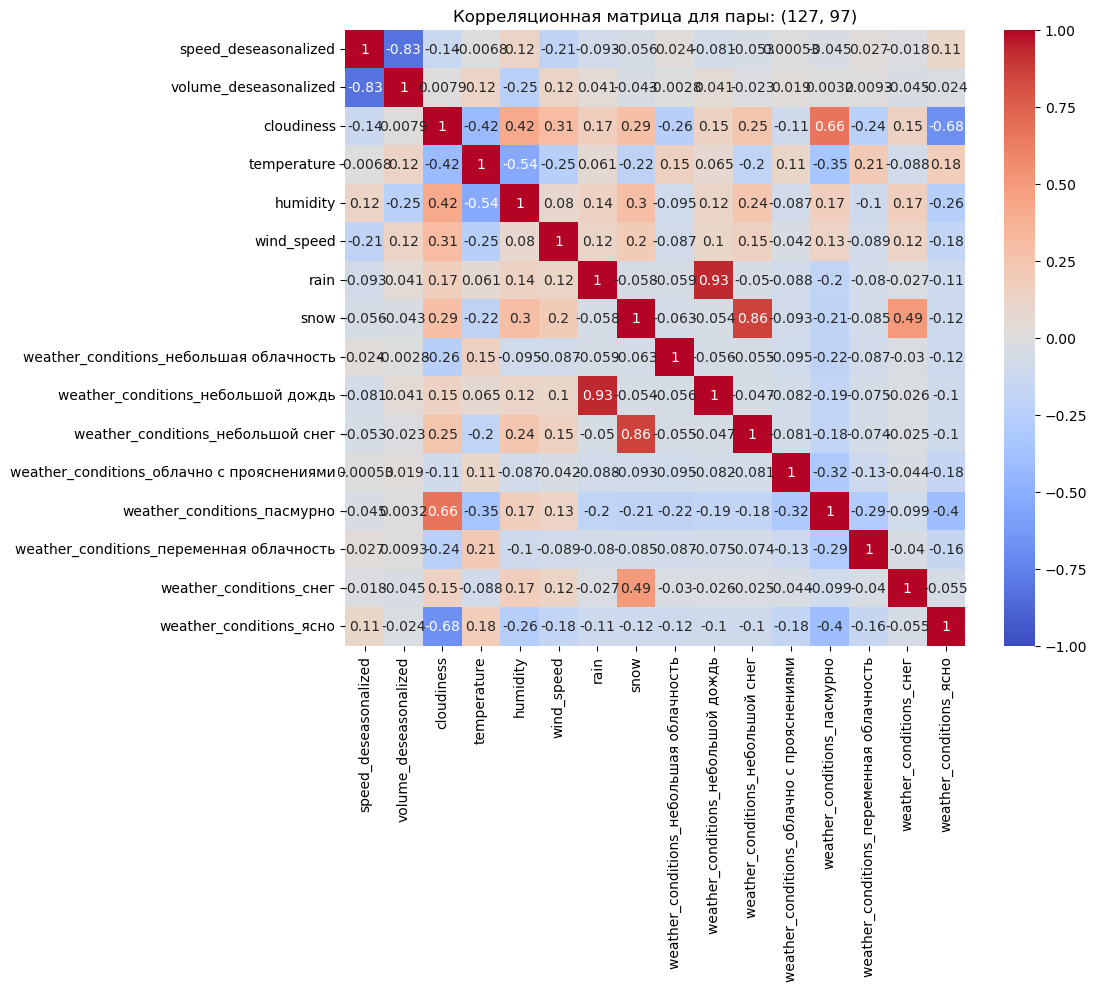

In [62]:
for (cross1_val, cross2_val), df_cross in merged_df_filtered.groupby(['cross1', 'cross2']):
    
    correlation_matrix = df_cross[['speed_deseasonalized', 'volume_deseasonalized', 'cloudiness', 'temperature', 'humidity', 
                                   'wind_speed', 'rain', 'snow', 
                                   'weather_conditions_небольшая облачность', 
                                   'weather_conditions_небольшой дождь', 
                                   'weather_conditions_небольшой снег', 
                                   'weather_conditions_облачно с прояснениями', 
                                   'weather_conditions_пасмурно', 
                                   'weather_conditions_переменная облачность', 
                                   'weather_conditions_снег', 
                                   'weather_conditions_ясно']].corr(method='spearman')

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Корреляционная матрица для пары: ({cross1_val}, {cross2_val})')
    plt.show()

Максимальные корреляции не превосходят по абсолютной величине 0.2, что незначительно.

#### Общая корр. матрица без учета направления движения 

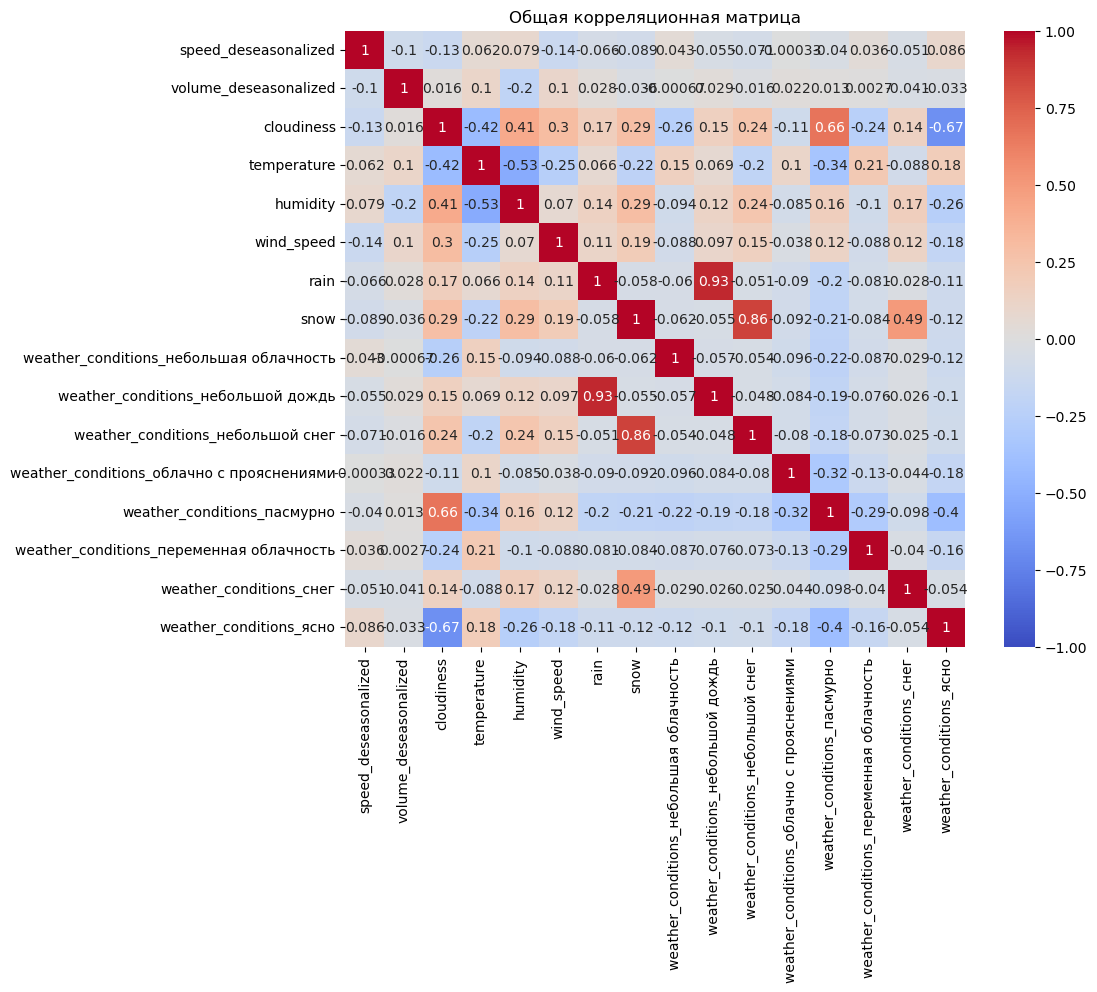

In [65]:
correlation_matrix = merged_df_filtered[['speed_deseasonalized', 'volume_deseasonalized', 'cloudiness', 'temperature', 'humidity', 
                                 'wind_speed', 'rain', 'snow', 
                                 'weather_conditions_небольшая облачность', 
                                 'weather_conditions_небольшой дождь', 
                                 'weather_conditions_небольшой снег', 
                                 'weather_conditions_облачно с прояснениями', 
                                 'weather_conditions_пасмурно', 
                                 'weather_conditions_переменная облачность', 
                                 'weather_conditions_снег', 
                                 'weather_conditions_ясно']].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Общая корреляционная матрица')
plt.show()

### Регрессионный 

In [67]:
for (cross1_val, cross2_val), df_cross in merged_df_filtered.groupby(['cross1', 'cross2']):
    
    X = df_cross[['cloudiness', 'temperature', 'humidity', 'wind_speed', 
                  'weather_conditions_небольшая облачность', 
                  'weather_conditions_небольшой дождь', 
                  'weather_conditions_небольшой снег', 
                  'weather_conditions_облачно с прояснениями', 
                  'weather_conditions_пасмурно', 
                  'weather_conditions_переменная облачность', 
                  'weather_conditions_снег', 
                  'weather_conditions_ясно']]
    
    y_speed = df_cross['speed_deseasonalized']
    
    X = sm.add_constant(X)
    
    model_speed = sm.OLS(y_speed, X).fit()
    
    print(f'Результаты регрессионного анализа для пары: ({cross1_val}, {cross2_val})')
    print(model_speed.summary())

Результаты регрессионного анализа для пары: (93, 97)
                             OLS Regression Results                             
Dep. Variable:     speed_deseasonalized   R-squared:                       0.088
Model:                              OLS   Adj. R-squared:                  0.085
Method:                   Least Squares   F-statistic:                     34.41
Date:                  Tue, 24 Sep 2024   Prob (F-statistic):           5.15e-77
Time:                          23:53:39   Log-Likelihood:                -14311.
No. Observations:                  4302   AIC:                         2.865e+04
Df Residuals:                      4289   BIC:                         2.873e+04
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [68]:
for (cross1_val, cross2_val), df_cross in merged_df_filtered.groupby(['cross1', 'cross2']):
    
    X = df_cross[['cloudiness', 'temperature', 'humidity', 'wind_speed', 
                  'weather_conditions_небольшая облачность', 
                  'weather_conditions_небольшой дождь', 
                  'weather_conditions_небольшой снег', 
                  'weather_conditions_облачно с прояснениями', 
                  'weather_conditions_пасмурно', 
                  'weather_conditions_переменная облачность', 
                  'weather_conditions_снег', 
                  'weather_conditions_ясно']]
    
    y_speed = df_cross['volume_deseasonalized']
    
    X = sm.add_constant(X)
    
    model_speed = sm.OLS(y_speed, X).fit()
    
    print(f'Результаты регрессионного анализа для пары: ({cross1_val}, {cross2_val})')
    print(model_speed.summary())

Результаты регрессионного анализа для пары: (93, 97)
                              OLS Regression Results                             
Dep. Variable:     volume_deseasonalized   R-squared:                       0.090
Model:                               OLS   Adj. R-squared:                  0.087
Method:                    Least Squares   F-statistic:                     35.20
Date:                   Tue, 24 Sep 2024   Prob (F-statistic):           7.25e-79
Time:                           23:53:39   Log-Likelihood:                -49338.
No. Observations:                   4302   AIC:                         9.870e+04
Df Residuals:                       4289   BIC:                         9.879e+04
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------

У большого количества погодных условий `P>|t|`, переменные имеют влияние на целевые метрику (что также подтверждается высокими `F-statistic`), но объяснительная сила линейной регресии мала, о чем свидельствуют низкие значения `R-squared`.

#### Результаты регрессионного анализа без учета направления движения

In [71]:
X = merged_df_filtered[['cloudiness', 'temperature', 'humidity', 'wind_speed', 
                'weather_conditions_небольшая облачность', 
                'weather_conditions_небольшой дождь', 
                'weather_conditions_небольшой снег', 
                'weather_conditions_облачно с прояснениями', 
                'weather_conditions_пасмурно', 
                'weather_conditions_переменная облачность', 
                'weather_conditions_снег', 
                'weather_conditions_ясно']]

y_speed = merged_df_filtered['speed_deseasonalized']
X = sm.add_constant(X)

model_speed = sm.OLS(y_speed, X).fit()
print('Результаты регрессионного анализа для всей выборки (скорость):')
print(model_speed.summary())

y_volume = merged_df_filtered['volume_deseasonalized']
model_volume = sm.OLS(y_volume, X).fit()
print('Результаты регрессионного анализа для всей выборки (объем):')
print(model_volume.summary())


Результаты регрессионного анализа для всей выборки (скорость):
                             OLS Regression Results                             
Dep. Variable:     speed_deseasonalized   R-squared:                       0.073
Model:                              OLS   Adj. R-squared:                  0.072
Method:                   Least Squares   F-statistic:                     55.15
Date:                  Tue, 24 Sep 2024   Prob (F-statistic):          1.13e-128
Time:                          23:53:39   Log-Likelihood:                -29640.
No. Observations:                  8379   AIC:                         5.931e+04
Df Residuals:                      8366   BIC:                         5.940e+04
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------

### Хи-квадрат

In [73]:
merged_df_filtered['speed_category'] = pd.qcut(merged_df_filtered['speed_deseasonalized'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
merged_df_filtered['volume_category'] = pd.qcut(merged_df_filtered['volume_deseasonalized'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

/tmp/ipykernel_190441/2747995965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_filtered['speed_category'] = pd.qcut(merged_df_filtered['speed_deseasonalized'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
/tmp/ipykernel_190441/2747995965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_filtered['volume_category'] = pd.qcut(merged_df_filtered['volume_deseasonalized'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])


In [74]:
for (cross1_val, cross2_val), df_cross in merged_df_filtered.groupby(['cross1', 'cross2']):
    
    contingency_table = pd.crosstab(df_cross['weather_conditions'], df_cross['speed_category'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f'Пара: ({cross1_val}, {cross2_val})')
    print(f'Chi2 Statistic: {chi2}, p-value: {p}')
    print(contingency_table)
    print('---')

Пара: (93, 97)
Chi2 Statistic: 248.59210357516005, p-value: 3.138073201202187e-39
speed_category           Q1   Q2   Q3   Q4
weather_conditions                        
дождь                    11    4    4    9
небольшая облачность     17   68   59  117
небольшой дождь          55   35   49   72
небольшой снег           30   72   55   25
облачно с прояснениями   39  200  129  170
пасмурно                190  604  511  503
переменная облачность    29  144  107  166
снег                     16   27   10    3
ясно                     46  240  184  302
---
Пара: (127, 97)
Chi2 Statistic: 121.45407169450223, p-value: 5.340475910864785e-15
speed_category           Q1   Q2   Q3   Q4
weather_conditions                        
дождь                    14    7    2    1
небольшая облачность     98   43   47   59
небольшой дождь          92   60   24   11
небольшой снег           86   30   49   16
облачно с прояснениями  208   87  118   89
пасмурно                733  272  410  290
переменная обл

In [75]:
for (cross1_val, cross2_val), df_cross in merged_df_filtered.groupby(['cross1', 'cross2']):
    
    contingency_table = pd.crosstab(df_cross['weather_conditions'], df_cross['volume_category'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f'Пара: ({cross1_val}, {cross2_val})')
    print(f'Chi2 Statistic: {chi2}, p-value: {p}')
    print(contingency_table)
    print('---')

Пара: (93, 97)
Chi2 Statistic: 41.01739087281279, p-value: 0.016583929553904458
volume_category          Q1   Q2   Q3   Q4
weather_conditions                        
дождь                     7    3    6   12
небольшая облачность     44   50   36  131
небольшой дождь          23   46   30  112
небольшой снег           31   39   28   84
облачно с прояснениями   71  103   94  270
пасмурно                293  348  246  921
переменная облачность    64   93   72  217
снег                     15   14    8   19
ясно                    129  174  140  329
---
Пара: (127, 97)
Chi2 Statistic: 26.78732847719233, p-value: 0.043908326453657824
volume_category          Q1   Q2   Q3
weather_conditions                   
дождь                     8    7    9
небольшая облачность     85   76   86
небольшой дождь          54   52   81
небольшой снег           61   68   52
облачно с прояснениями  160  157  185
пасмурно                596  505  604
переменная облачность   143  134  154
снег                

Высокое значение `Chi2` и крайне низкий `p-value` сигнализируют о значительной связи между погодными условиями и категориями скоростей и объема трафика. Из-за дисбаланса классов хи-квадрат занижает `p-value`, но его настоящее значение все еще очень мало.

#### Тест хи-квадрат без учета направления движения

In [78]:
contingency_table = pd.crosstab(merged_df_filtered['weather_conditions'], merged_df_filtered['speed_category'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print('Chi2 Statistic:', chi2)
print('p-value:', p)
print(contingency_table)

Chi2 Statistic: 205.33764384138698
p-value: 9.656683045034202e-31
speed_category           Q1   Q2   Q3   Q4
weather_conditions                        
дождь                    25   11    6   10
небольшая облачность    115  111  106  176
небольшой дождь         147   95   73   83
небольшой снег          116  102  104   41
облачно с прояснениями  247  287  247  259
пасмурно                923  876  921  793
переменная облачность   194  208  232  243
снег                     41   36   24   10
ясно                    287  369  381  480


### ML

Продемонстрируем возможность построения моделей на самом простом примере для одного направления.

In [81]:
df_cross_one_pair = merged_df_filtered[(merged_df_filtered['cross1'] == 127) & (merged_df_filtered['cross2'] == 97)]

In [82]:
X = df_cross_one_pair.drop(columns=['speed_deseasonalized', 'volume_deseasonalized', 'measuretimeutc', 
                                'weather_conditions', 'cross1', 'cross2', 'direct', 'speed_category', 'volume_category']) 

y = df_cross_one_pair['speed_deseasonalized']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [85]:
y_pred = model.predict(X_test)

In [86]:
rmse = (mean_squared_error(y_test, y_pred))**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 7.793588056285727
Mean Absolute Error: 6.5166444430556325
R-squared: 0.3016359906368876


Как видим, самая простая модель RFR без какой-либо тонкой настройки ошибается в среднем на 6.5 км/ч, при наличии только погодных условий в качестве фич.

# Вывод

Был проведен EDA и анализ временного ряда.
Было проведен статистический анализ влияния погоды на среднюю скорость автомобилей, а именно корреляционный, регрессионный анализы и хи-квадрат тест.
* Корреляционный анализ не выявил значимых зависимостей, что скорее всего обусловлено нелинейным характером зависимостей и комплексностью
* Регрессионный анализ показал, что погодные условия имеют статичтически значимое влияние на целевые переменные, что подтверждено высокими `p-value` и `F-statistic`, но, опять же, в связи с нелинейным характером зависимостей линейная регрессионная имеет низкую объяснительную способность, что отражено в низком `R-square`
* Тест хи-квадрат подтвердил статичтическую значимость влияния погодных условий на целевые признаки.
* Sanity check: простейшая RFR модель при наличии только лишь погодных условий предсказывает целевой признак скорость с `MAE`=6.5 и `R-squared`=0.3, что очень неплохо для real-world эмприрических данных

Исходя из проведенной работы можно с уверенностью утдвердить о наличии значимой зависимости между погодными условиями и трафиком, пусть нелинейных и сложных. На их основе можно строить модели машинного обучения и т.п.